# Ex 2. Low-activity patterns
**2.1.** We now study the capacity of a Hopfield network with stochastic binary neurons and low-activity patterns. This model is proposed in the paper by [Tsodyks and Feigel’man (1988)] and discussed briefly in Chapter 17.2.6 of the book Neuronal Dynamics.

Standard Hopfield model could be described by the following equations:

\begin{equation}
w_{ij} = c \sum_{\mu=1}^{M} p_{i}^{\mu}p_{j}^{\mu}
\end{equation}

\begin{equation}
S_{i}(t+1) = \phi(\sum_{j} w_{ij} S_{j}(t))
\end{equation}
Taking $p_{i}^{\mu} = 2\xi_{i}^{\mu}-1$ we can substitute it into expression (1):
\begin{equation}
    w_{ij} = c \sum_{\mu=1}^{M} (2\xi_{i}^{\mu}-1)(2\xi_{j}^{\mu}-1)
\end{equation}

$$ = 4c \sum_{\mu=1}^{M} (\xi_{i}^{\mu}-\frac{1}{2})(\xi_{j}^{\mu}-\frac{1}{2})$$
$$ = 4c \sum_{\mu=1}^{M} (\xi_{i}^{\mu}-a)(\xi_{j}^{\mu}-b)$$
Hence, from this expression we can deduce that if $a=b=0.5$ with $c^{'}=4c$, we arrive at the Standard Hopfiel model.

The two models would be equivalent if the patterns of -1 and 1 are considered.

**2.2.** Write methods for generating random patterns ξμ ∈ {0, 1}$^{N}$ with activity (i.e. average number of (+1)’s) a, for computing the Hamming distance between new patterns ξμ and new state variables σ, and for simulating the new model above.

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [96]:
def generate_patterns(M, N):
    """
    Args:
        M: number of patterns
        N: number of neurons
    Output:
        Generates binary balanced random patterns.
    """
    patterns = np.random.choice([0, 1], size=(M, N))
    a = np.mean(patterns)
    return patterns, a

def generate_patterns_with_low_activity(M, N, a):
    """
    Args:
        M: number of patterns
        N: number of neurons
    Output:
        Generates binary balanced random patterns.
    """
    patterns = np.random.choice([0, 1], size=(M, N), p=[1-a, a])
    return patterns

class LowActivityHopfield:
    def __init__(self, beta, theta):
        self.beta = beta
        self.theta = theta
        self.k = 50

    def compute_overlap(self, sigma, patterns, a):
        overlap = np.zeros(patterns.shape[0])
        for mu in range(patterns.shape[0]):
            overlap[mu] = np.dot(patterns[mu] - a, sigma)
        return overlap
    
    def compute_state(self, overlap, patterns, a, b, N):
        state = np.zeros(N)
        c = 2/(a*(1-a))
        for i in range(N):         
            prod = (patterns[:,i] - b) * overlap
            #print(np.tanh(c/N * prod.sum() - self.theta))
            state[i] = np.tanh(2*c/N*np.sum(prod) - self.theta)
        return state
    
    def stochastic_var(self, state):
        firing_probability = 0.5 * (state + 1) 
        sigma = np.random.binomial(1, firing_probability) # P{σ_i(t) = +1 | S_i(t)}
        return sigma
    
    def hamming_distance(self, state1, state2, N):
        #print(np.dot(state2, state1))
        ham_dist = np.zeros(state2.shape[0])
        for mu in range(state2.shape[0]):
            ham_dist[mu] = (N - np.sum(state2[mu]==state1))/(2*N)
        return ham_dist

    def simulate(self, patterns, state, a, b, N):
        states = []
        hamming_distances = [self.hamming_distance(state, patterns, N)]
        overlaps = []
        for i in range(self.k):
            overlap = self.compute_overlap(state, patterns, a)
            overlaps.append(overlap)
            state = self.compute_state(overlap, patterns, a, b, N)
            state = self.stochastic_var(state)
            states.append(state)
            hamming_distances.append(self.hamming_distance(state, patterns, N))
        return states, hamming_distances, overlaps

In [97]:
# Constants for simulation
N = 300  # Number of neurons
M = 10    # Number of patterns
a = 0.5  # Low activity level
b = 0.5  # Constant b as per project description
c = 4*2/a*(1-a) # Constant c as per project description

# Generate patterns and compute weights
low_activity_patterns, a_new = generate_patterns(M, N)
print(a_new)

# Set the initial state close to one of the patterns and simulate
theta = 0    # Example threshold
beta = 4     # Example beta value

model = LowActivityHopfield(beta, theta)
initial_state = low_activity_patterns[0].copy() # already initialised as sigma (zeros and ones)
# flip 5% of the bits
initial_state[np.random.choice(N, int(0.05*N), replace=False)] *= -1
states, hamming_distances, overlaps = model.simulate(low_activity_patterns, initial_state, a, b, N)

0.5013333333333333


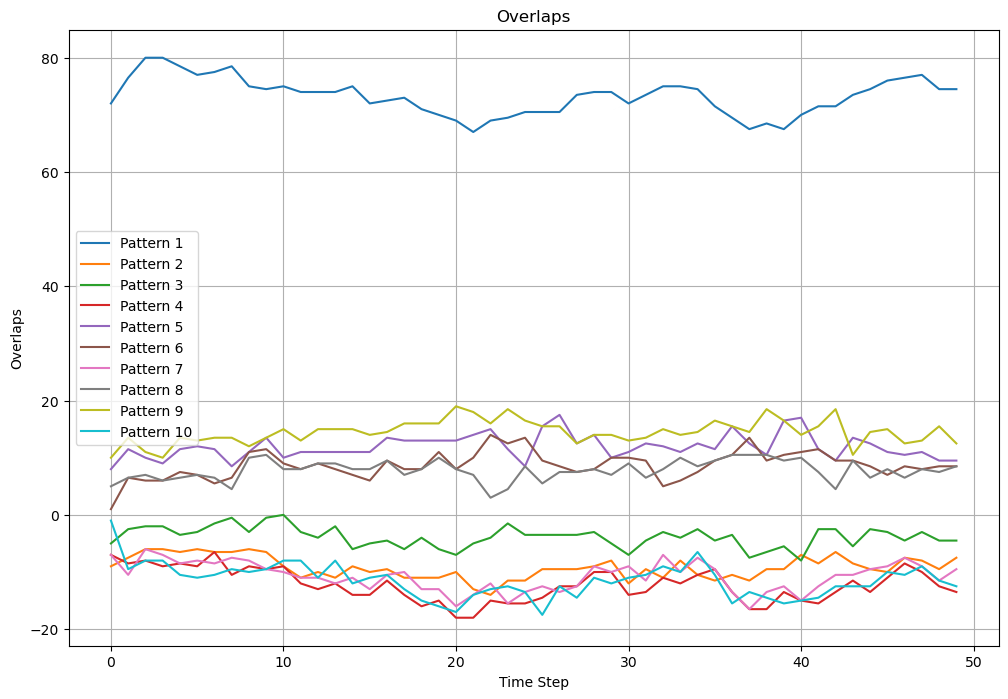

In [98]:
# Plotting the overlaps

overlaps = np.array(overlaps)
plt.figure(figsize=(12, 8))
for i in range(overlaps.shape[1]):
    plt.plot(overlaps[:, i], label=f'Pattern {i+1}')
plt.xlabel('Time Step')
plt.ylabel('Overlaps')
plt.title('Overlaps')
plt.legend()
plt.grid()
plt.show()


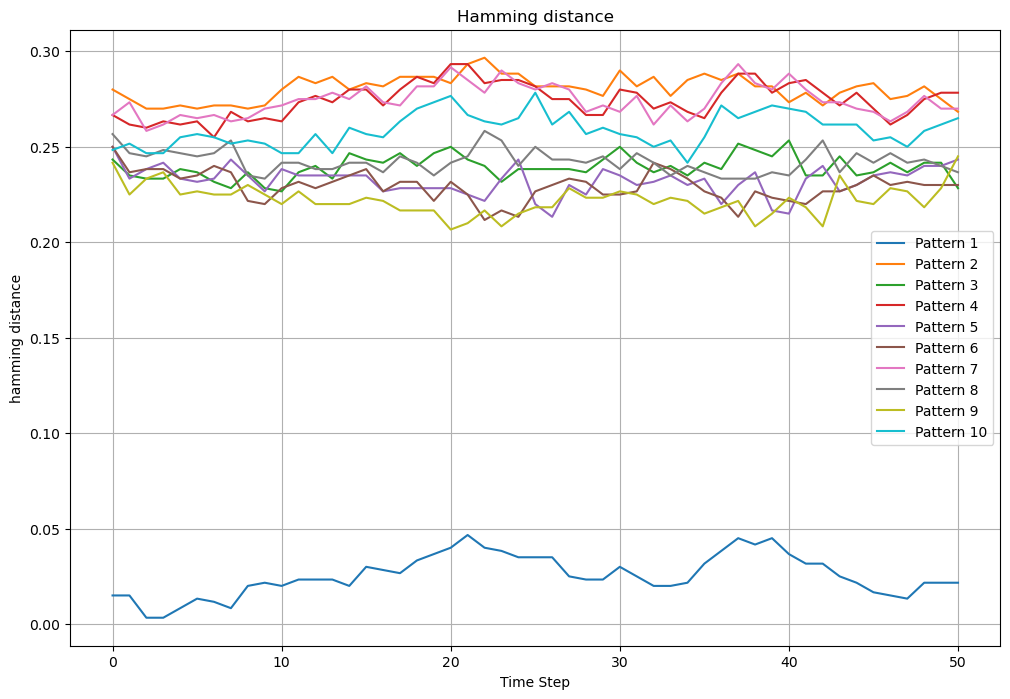

In [99]:
# Plotting the overlaps
hamming_distances = np.array(hamming_distances)
plt.figure(figsize=(12, 8))
for i in range(hamming_distances.shape[1]):
    plt.plot(hamming_distances[:, i], label=f'Pattern {i+1}')
plt.xlabel('Time Step')
plt.ylabel('hamming distance')
plt.title('Hamming distance')
plt.grid()
plt.legend()
plt.show()


As expected we successfully retrieve one of the patterns.

**2.3.** Using the parameters a, b, θ that you found in question 2.1, compute the capacity of the network for N = 300.
Is it the same as what you found in the previous section? If not, what do you think is the origin of the discrepancy?

Therefore, parameters considered in this section are the following:
- $a=0.5$
- $b=0.5$
- $\theta$ = $0$

In [82]:
def retrieve_patterns(hamming_distances, N, retrieve_final=True):
    """
    Calculates the retrieval error and counts the number of successfully retrieved patterns.
    
    Parameters:
    - hamming_distances (np.ndarray): A 2D array (time_steps, patterns) of Hamming distances.

    Returns:
    - error (float): The average error of pattern retrieval.
    - retrieved_count (int): The number of patterns successfully retrieved.
    """
    
    # Assume final states are the last recorded Hamming distances (i.e., at the last time step)
    if retrieve_final:
        final_states = hamming_distances[-1, :]
    else:
        final_states = hamming_distances
    
    # Calculate the error of pattern retrieval (average of last row, i.e., final Hamming distances)
    error = np.mean(final_states)
    
    # Calculate the number of patterns retrieved: DH(Pμ, Sfμ) ≤ 0.05
    # This threshold should be based on the length of the patterns, assumed here as directly proportional
    retrieval_threshold = 0.05
    retrieved_count = np.sum(final_states <= retrieval_threshold)
    
    return error, retrieved_count/N


print("Error and capacity of the network:",retrieve_patterns(hamming_distances, 300))

Error and capacity of the network: (0.23183333333333334, 0.0033333333333333335)


In [83]:
def hamming_distance(patterns, state):
    """
    Calculate the overlap between the final state and the stored patterns.
    """
    overlaps = []
    for pattern in patterns:
        #state_adapted = state.copy()
        #state_adapted[state >= 0] = 1
        #state_adapted[state < 0] = -1
        overlap = (N-np.dot(pattern * 2 - 1, state))/(2*N)
        overlaps.append(overlap)
    return overlaps

In [84]:
# Parameters are the same from before

# Set the initial state close to one of the patterns and simulate
simulation_steps = 10

# Storing capacities for each theta and each simulation
capacities = []

for sim in range(simulation_steps):
    model = LowActivityHopfield(beta=4, theta=theta)
    low_activity_patterns = generate_patterns_with_low_activity(M, N, a)
    cap = 0
    for mu in range(M):
        initial_state = low_activity_patterns[mu].copy()  # already initialised as sigma (zeros and ones)
        # flip 5% of the bits
        initial_state[np.random.choice(N, int(0.05*N), replace=False)] *= -1

        states, hamming_distances, overlaps = model.simulate(low_activity_patterns, initial_state, a, b, N)
        hamming_distances = np.array(hamming_distances)
        overlaps = np.array(overlaps)
        cap += retrieve_patterns(hamming_distances, N)[1]
    capacities.append(cap)

# Calculate mean and standard deviation of capacities
mean_capacity = np.array(capacities).mean()
std_capacity = np.array(capacities).std()

# Plotting capacities and their standard deviations
#plt.figure(figsize=(12, 8))
#plt.plot(capacities, '-o', label='Capacity')
#plt.xlabel('Simulation steps')
#plt.ylabel('Capacity')
#plt.title(f'Capacity vs Theta Value for a={a} and b={b}')
#plt.grid()
#plt.legend()
#plt.show()

print("Mean capacity:", mean_capacity)
print("Standard deviation of capacity:", std_capacity)

Mean capacity: 0.020333333333333335
Standard deviation of capacity: 0.008621678104251709


**Answer:** The capacity of the network is similar, meaning that it retrieves one pattern. Nonetheless, since the model is stochastic that's not always the case and sometimes the capacity could be lower.

**2.4.** For a = b = 0.5, what value of the threshold θ corresponds to the best capacity? Plot the capacity as a function of θ.

100%|██████████| 20/20 [02:16<00:00,  6.81s/it]


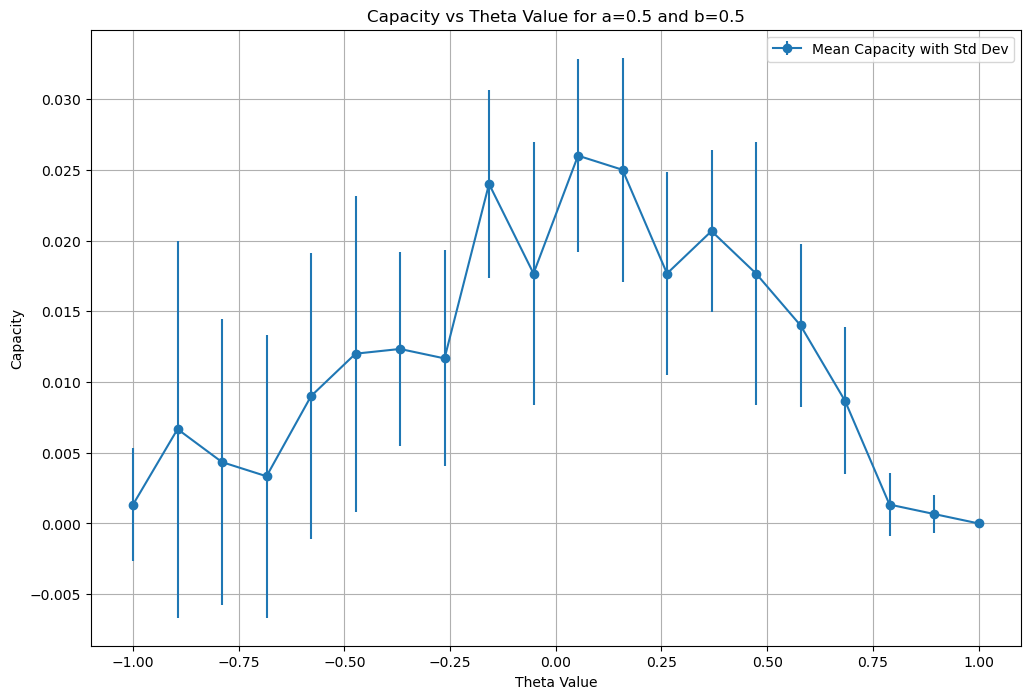

In [62]:
# Constants for simulation
N = 300  # Number of neurons
M = 10   # Number of patterns
a = 0.5  # Low activity level
b = 0.5  # Constant b as per project description
theta_list = np.linspace(-1, 1, 20)  # Threshold values to test

# Set the initial state close to one of the patterns and simulate
simulation_steps = 10

# Storing capacities for each theta and each simulation
all_capacities = [[] for _ in theta_list]

for i, theta in enumerate(tqdm.tqdm(theta_list)):
    for sim in range(simulation_steps):
        model = LowActivityHopfield(beta=4, theta=theta)
        low_activity_patterns = generate_patterns_with_low_activity(M, N, a)
        cap = 0
        for mu in range(M):
            initial_state = low_activity_patterns[mu].copy()  # already initialised as sigma (zeros and ones)
            # flip 5% of the bits
            initial_state[np.random.choice(N, int(0.05*N), replace=False)] *= -1

            states, hamming_distances, overlaps = model.simulate(low_activity_patterns, initial_state, a, b, N)
            hamming_distances = np.array(hamming_distances)
            overlaps = np.array(overlaps)
            cap += retrieve_patterns(hamming_distances, N)[1]
        all_capacities[i].append(cap)

# Calculate mean and standard deviation of capacities
mean_capacities = [np.mean(cap) for cap in all_capacities]
std_capacities = [np.std(cap) for cap in all_capacities]

# Plotting capacities and their standard deviations
plt.figure(figsize=(12, 8))
plt.errorbar(theta_list, mean_capacities, yerr=std_capacities, fmt='-o', label='Mean Capacity with Std Dev')
plt.xlabel('Theta Value')
plt.ylabel('Capacity')
plt.title(f'Capacity vs Theta Value for a={a} and b={b}')
plt.grid()
plt.legend()
plt.show()

In [29]:
#plt.plot(theta_list[400:800],capacities[400:800])
print("Error and capacity of the network:",retrieve_patterns(hamming_distances, 300, False))

Error and capacity of the network: (0.24387254901960784, 0.006666666666666667)


**Answer**: The closer the theta is to 1, the more likely we are to retrieve patterns.

**2.5.** Now, we go to the low-activity case. Repeat the previous question for a = b = 0.1 and a = b = 0.05. What is the optimal value of θ in this case? Compare the capacity of the low-activity networks with that of the balanced network.
Hint: as it can be long to simulate, adapt the value of the maximal loading to the value of θ. Try high loadings only for θ close to the optimal value.

100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


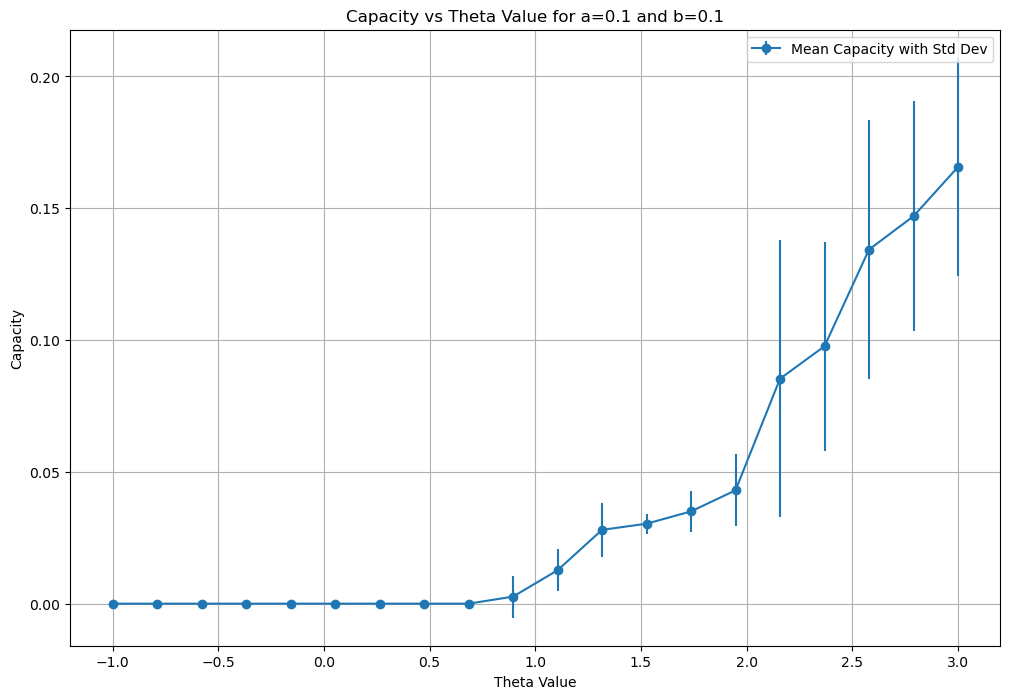

In [40]:
# Constants for simulation
N = 300  # Number of neurons
M = 10   # Number of patterns
a = 0.1  # Low activity level
b = 0.1  # Constant b as per project description
theta_list = np.linspace(-1, 3, 20)  # Threshold values to test

# Set the initial state close to one of the patterns and simulate
simulation_steps = 10

# Storing capacities for each theta and each simulation
all_capacities = [[] for _ in theta_list]

for i, theta in enumerate(tqdm.tqdm(theta_list)):
    for sim in range(simulation_steps):
        model = LowActivityHopfield(beta=4, theta=theta)
        low_activity_patterns = generate_patterns_with_low_activity(M, N, a)
        cap = 0
        for mu in range(M):
            initial_state = low_activity_patterns[mu].copy()  # already initialised as sigma (zeros and ones)
            # flip 5% of the bits
            initial_state[np.random.choice(N, int(0.05*N), replace=False)] *= -1

            states, hamming_distances, overlaps = model.simulate(low_activity_patterns, initial_state, a, b, N)
            hamming_distances = np.array(hamming_distances)
            overlaps = np.array(overlaps)
            cap += retrieve_patterns(hamming_distances, N)[1]
        all_capacities[i].append(cap)

# Calculate mean and standard deviation of capacities
mean_capacities = [np.mean(cap) for cap in all_capacities]
std_capacities = [np.std(cap) for cap in all_capacities]

# Plotting capacities and their standard deviations
plt.figure(figsize=(12, 8))
plt.errorbar(theta_list, mean_capacities, yerr=std_capacities, fmt='-o', label='Mean Capacity with Std Dev')
plt.xlabel('Theta Value')
plt.ylabel('Capacity')
plt.title(f'Capacity vs Theta Value for a={a} and b={b}')
plt.grid()
plt.legend()
plt.show()

100%|██████████| 10/10 [00:48<00:00,  4.81s/it]


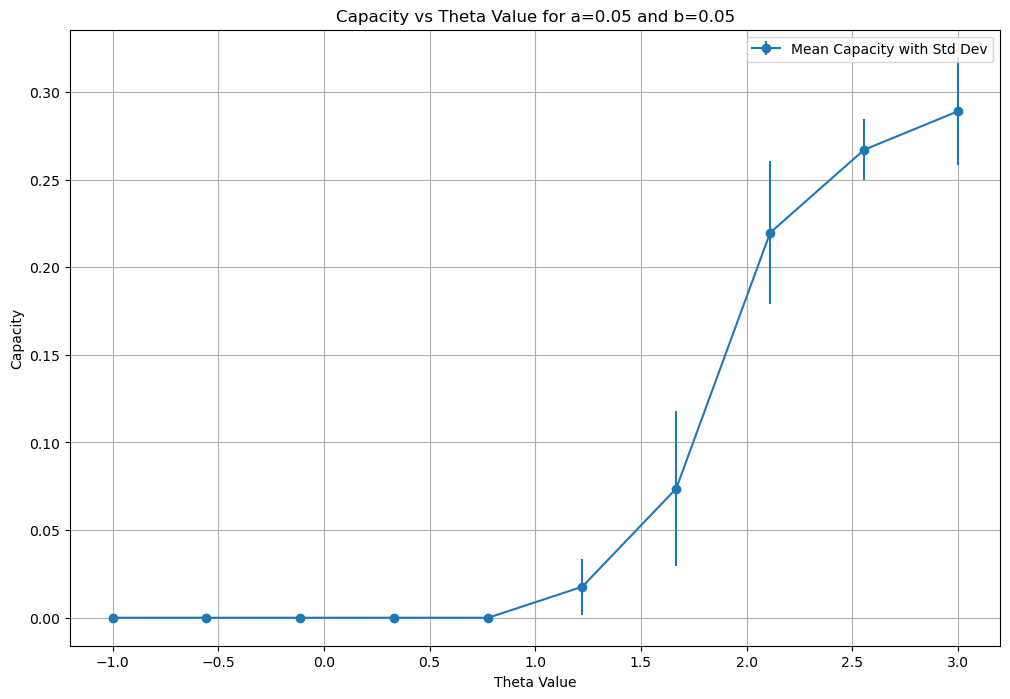

In [35]:
# Constants for simulation
N = 300  # Number of neurons
M = 10   # Number of patterns
a = 0.05  # Low activity level
b = 0.05  # Constant b as per project description
theta_list = np.linspace(-1, 3, 10)  # Threshold values to test

# Set the initial state close to one of the patterns and simulate
simulation_steps = 10

# Storing capacities for each theta and each simulation
all_capacities = [[] for _ in theta_list]

for i, theta in enumerate(tqdm.tqdm(theta_list)):
    for sim in range(simulation_steps):
        model = LowActivityHopfield(beta=4, theta=theta)
        low_activity_patterns = generate_patterns_with_low_activity(M, N, a)
        cap = 0
        for mu in range(M):
            initial_state = low_activity_patterns[mu].copy()  # already initialised as sigma (zeros and ones)
            # flip 5% of the bits
            initial_state[np.random.choice(N, int(0.05*N), replace=False)] *= -1

            states, hamming_distances, overlaps = model.simulate(low_activity_patterns, initial_state, a, b, N)
            hamming_distances = np.array(hamming_distances)
            overlaps = np.array(overlaps)
            cap += retrieve_patterns(hamming_distances, N)[1]
        all_capacities[i].append(cap)

# Calculate mean and standard deviation of capacities
mean_capacities = [np.mean(cap) for cap in all_capacities]
std_capacities = [np.std(cap) for cap in all_capacities]

# Plotting capacities and their standard deviations
plt.figure(figsize=(12, 8))
plt.errorbar(theta_list, mean_capacities, yerr=std_capacities, fmt='-o', label='Mean Capacity with Std Dev')
plt.xlabel('Theta Value')
plt.ylabel('Capacity')
plt.title(f'Capacity vs Theta Value for a={a} and b={b}')
plt.grid()
plt.legend()
plt.show()

**2.6.** (Bonus) In the low-activity case (a = 0.1), try asymmetric connectivities by varying the value of b. Which combination of the parameters b and θ gives you the best capacity?

100%|██████████| 11/11 [08:54<00:00, 48.59s/it]


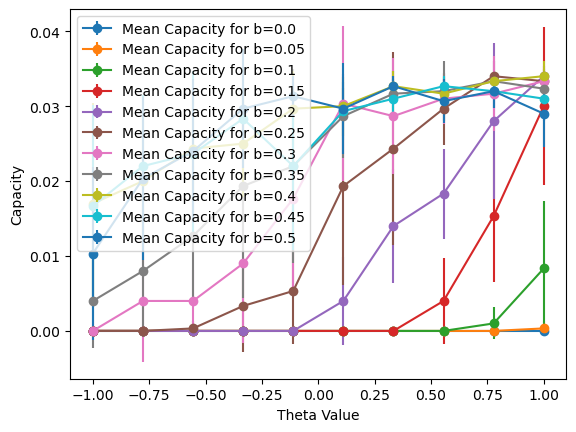

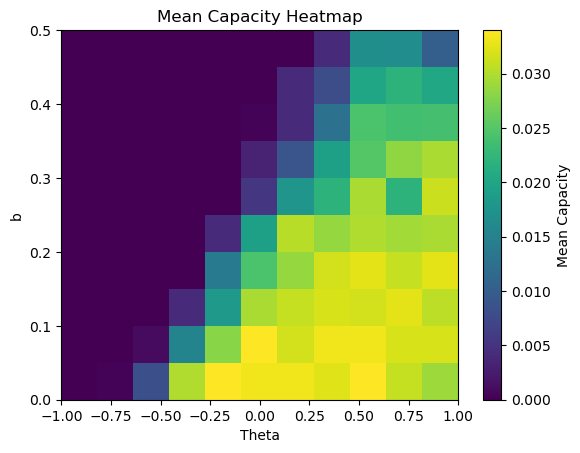

In [86]:
# Constants for simulation
N = 300  # Number of neurons
M = 10   # Number of patterns
a = 0.1  # Low activity level
b_list = np.arange(0, 0.55, 0.05)  # Constant b as per project description
theta_list = np.linspace(-1, 1, 10)  # Threshold values to test

# Set the initial state close to one of the patterns and simulate
simulation_steps = 10


def simulate_low_activity(N, M, a, b, theta_list, simulation_steps=10):
    # Storing capacities for each theta and each simulation
    all_capacities = [[] for _ in theta_list]

    for i, theta in enumerate(tqdm.tqdm(theta_list)):
        for sim in range(simulation_steps):
            model = LowActivityHopfield(beta=4, theta=theta)
            low_activity_patterns = generate_patterns_with_low_activity(M, N, a)
            cap = 0
            for mu in range(M):
                initial_state = low_activity_patterns[mu].copy()  # already initialised as sigma (zeros and ones)
                # flip 5% of the bits
                initial_state[np.random.choice(N, int(0.05*N), replace=False)] *= -1

                states, hamming_distances, overlaps = model.simulate(low_activity_patterns, initial_state, a, b, N)
                hamming_distances = np.array(hamming_distances)
                overlaps = np.array(overlaps)
                cap += retrieve_patterns(hamming_distances, N)[1]
            all_capacities[i].append(cap)

    # Calculate mean and standard deviation of capacities
    mean_capacities = [np.mean(cap) for cap in all_capacities]
    std_capacities = [np.std(cap) for cap in all_capacities]
    return mean_capacities, std_capacities

capacity_results = np.zeros((len(theta_list), len(b_list)))
capacity_stds = np.zeros((len(theta_list), len(b_list)))
for i,b in enumerate(tqdm.tqdm(b_list)):
    mean_capacities, std_capacities = simulate_low_activity(N, M, a, b, theta_list, simulation_steps)
    plt.errorbar(theta_list, mean_capacities, yerr=std_capacities, fmt='-o', label=f'Mean Capacity for b={round(b,3)}')
    plt.legend()
    plt.xlabel('Theta Value')
    plt.ylabel('Capacity')
    capacity_results[:, i] = mean_capacities
    capacity_stds[:, i] = std_capacities

# Plotting
fig, ax = plt.subplots()
cax = ax.imshow(capacity_results, interpolation='nearest', cmap='viridis', aspect='auto', extent=[theta_list[0], theta_list[-1], b_list[0], b_list[-1]])
ax.set_xlabel('Theta')
ax.set_ylabel('b')
ax.set_title('Mean Capacity Heatmap')
fig.colorbar(cax, ax=ax, label='Mean Capacity')

plt.show()